# Chap 03. Classification

---
## 3.1 MNIST

#### 3.1.1 MNIST 데이터셋 다운로드 받기

In [10]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame = False) ## 기본적으로 pandas dataframe인 데이터셋을 numpy로 받음

In [11]:
X, y = mnist.data, mnist.target

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


이미지가 70,000개 있고 각 이미지에는 784개의 특성이 있음을 확인한다.

이는 이미지가 28x28 픽셀이기 때문이다.

각각의 특성은 0(흰색)부터 255(검은색)까지의 픽셀 강도를 나타낸다.

#### 3.1.2 이미지 확인하기

<function matplotlib.pyplot.show(close=None, block=None)>

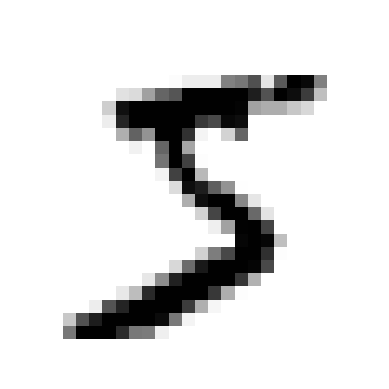

In [12]:
import matplotlib.pyplot as plt

def plot_digit(image_data) :
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap="binary") # 흑백 컬러맵 사용
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show

#### 3.1.3 훈련, 테스트셋 나누기

fetch_openml의 MNIST 데이터셋은 이미 훈련세트와 테스스 세트가 나뉘어져 있다.

그래서 해당 이미지 세트에 맞게 세트를 분리해준다.

In [13]:
X_train, X_test, y_train, y_test = X[:60000], X[60000], y[:60000], y[60000]

---

## 3.2 Binary Classifier (이진 분류기)

#### 3.2.1 5감지기 모델 생성하기

'5'와 '5가 아님' 두가지 클래스를 구분할 수 있는 이진 분류기를 생성해본다.

In [14]:
y_train_5 = (y_train == '5') ## 5는 True, 나머지는 False
y_test_5 = (y_test == '5')

이제 분류 모델 **Stochastic Gradient Descent** (SGD, 확률적 경사 하강법) 분류기로 훈련시켜본다.

SGD는 한 번에 하나씩 훈련 샘플을 독립적으로 처리할 수 있다.

In [16]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [17]:
sgd_clf.predict([some_digit])

array([ True])

이전에 some_digit을 X[0]즉 숫자 5 이미지로 설정하였다.

해당 이미지에 대해 True라고 추측하였으므로 기대한 결과를 얻을 수 있었다.

---
## 3.3 Model Performance Assessment (성능 측정)

#### 3.3.1 교차 검증을 사용한 정확도 측정


**k-fold 교차 검증**을 위해 데이터가 클래스별 비율이 유지되도록 폴드를 생성한다.

매 반복에서 분류기 객체를 복제하여 훈련 폴드로 훈련시키고 테스트 폴드로 예측을 만든다.

그 다음 올바른 예측 수를 세어 정확한 예측 비율을 출력한다.

In [18]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [20]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)

print(any(dummy_clf.predict(X_train)))

False


In [21]:
cross_val_score(dummy_clf, X_train, y_train_5,cv =3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

아무것도 학습하지 않은 dummy 분류기가 모든 데이터를 '5가 아님'이라고 예측 했음에도

정확도가 90%이상이 나옴을 확인할 수 있다.

분류기의 성능 측정 지표로 정확도를 선호하지 않는 이유이다.

#### 3.3.2 Confusion Matrix (오차 행렬)

**오차 행렬**이란 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것이다.

특정 클래스가 분류된 횟수를 보고 싶으면, 해당 행을 보면 된다.

오차 행렬을 만들려면 실제 타깃과 비교할 수 있도록 예측값을 만들어야 한다.

Cross Validation을 이용하여 학습에 포함되지 않은 out-of-sample에 대해서도

예측할 수 있도록 한다.

In [25]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [26]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5,y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

오차 행렬의 행은 **실제 클래스**를 나타내고 열은 **예측한 클래스**를 나타낸다.

위의 결과값을 분석하면, 53,892개를 '5 아님'으로 정확하게 분류했고 687개를 '5'라고 잘못 분류했다.

두 번째 행은 '5'이미지에 대한 것으로, 1,891개를 '5 아님'으로 잘못 분류했고

3,530개를 정확히 '5'라고 분류했다.

추가적으로, Confusuion Matrix는 클래스의 라벨을 오름차순으로 정렬하기 때문에

| - | 0 | 1 |
|:----------:|:----------:|:----------:|
| 0 | 53892  | 687  |
| 1 | 1891  | 3530  |

이런 형태가 된다.

#### 3.3.3 Precision& Recall (정밀도와 재현율)

더 요약된 지표인 정밀도의 식 :

$ \text{Precision} = \frac{TP}{TP + FP} $

TP는 True Positive, FP는  False Positive

정밀도와 같이 사용하는 재현율의 식 :

$ \text{Recall} = \frac{TP}{TP + FN} $

이제 사이킷런이 제공하는 함수를 이용하여 5-분류기에 대한 정밀도와 재현율을 얻어보자


In [28]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [29]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

이제 정밀도와 재현율을 F1 score라고 하는 하나의 숫자로 만들자.

F1 score는 정밀도와 재현율의 **조화 평균**이다.

마찬가지로 관련 함수를 호출하면 된다.

In [30]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847